# LÊ NGUYỄN TRUNG 19146024

## Code train model phân loại rác sử dụng CNN 

**1. Tải datasets từ Kaggle**

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!mkdir kaggle

In [3]:
import os
import json 
kaggleAPIToken = {"username":"lenguyentrung","key":"53097035ab313b0e4ac545a7637f04f9"}
with open('/content/kaggle/kaggle.json', 'w') as file:
    json.dump(kaggleAPIToken, file)

In [4]:
!chmod 600 /content/kaggle/kaggle.json
!sudo mkdir ~/.kaggle
!cp /content/kaggle/kaggle.json ~/.kaggle/kaggle.json
!mkdir dataset
!kaggle datasets download -d lenguyentrung/garbageonr

 96% 204M/213M [00:01<00:00, 125MB/s] 
100% 213M/213M [00:01<00:00, 133MB/s]


In [5]:
!unzip /content/garbageonr.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: DATASET/R/R_5499.jpg    
  inflating: DATASET/R/R_55.jpg      
  inflating: DATASET/R/R_550.jpg     
  inflating: DATASET/R/R_5500.jpg    
  inflating: DATASET/R/R_5501.jpg    
  inflating: DATASET/R/R_5502.jpg    
  inflating: DATASET/R/R_5503.jpg    
  inflating: DATASET/R/R_5504.jpg    
  inflating: DATASET/R/R_5505.jpg    
  inflating: DATASET/R/R_5506.jpg    
  inflating: DATASET/R/R_5507.jpg    
  inflating: DATASET/R/R_5508.jpg    
  inflating: DATASET/R/R_5509.jpg    
  inflating: DATASET/R/R_551.jpg     
  inflating: DATASET/R/R_5510.jpg    
  inflating: DATASET/R/R_5511.jpg    
  inflating: DATASET/R/R_5512.jpg    
  inflating: DATASET/R/R_5513.jpg    
  inflating: DATASET/R/R_5514.jpg    
  inflating: DATASET/R/R_5515.jpg    
  inflating: DATASET/R/R_5516.jpg    
  inflating: DATASET/R/R_5517.jpg    
  inflating: DATASET/R/R_5518.jpg    
  inflating: DATASET/R/R_5519.jpg    
  inflating: DATASET/R/R_552.jp

#Tải các thư viện cần thiết

In [6]:
import numpy as np
import pandas as pd
import os
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

## Chuẩn bị datasets

In [7]:
data_path = "/content/DATASET/" # Đường dẫn của dataset
categories = ['O', 'R'] 

In [8]:
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("_",x).start()] + '/' + x)
    return df

In [9]:
filenames_list = []
categories_list = []
for category in categories:
    filenames = os.listdir(data_path + category)  
    filenames_list += filenames
    categories_list += [category] * len(filenames)
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list})
df = add_class_name_prefix(df, 'filename')

df = df.sample(frac=1).reset_index(drop=True)

In [10]:
df.head(5)

,filename,category
0,R/R_2469.jpg,R
1,O/O_12712.jpg,O
2,O/O_13180.jpg,O
3,O/O_8473.jpg,O
4,R/R_5626.jpg,R


**In các ảnh ngẫu nhiên trong tập dữ liệu ứng với phân loại**

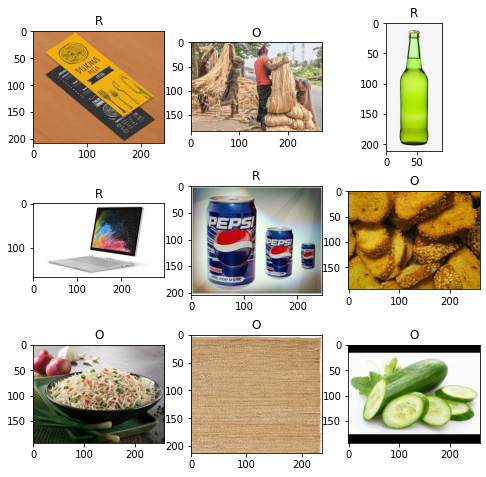

In [11]:
plt.figure(figsize=(8,8))
for i in range(9):
    random_row = random.randint(0, len(df)-1)
    sample = df.iloc[random_row]
    random_image = image.load_img(data_path + sample['filename'])
    plt.subplot(330 + 1 + i)
    plt.title(sample['category'])
    plt.imshow(random_image)
plt.show()

## Vẽ biểu đồ phân bố số lượng của từng loại rác

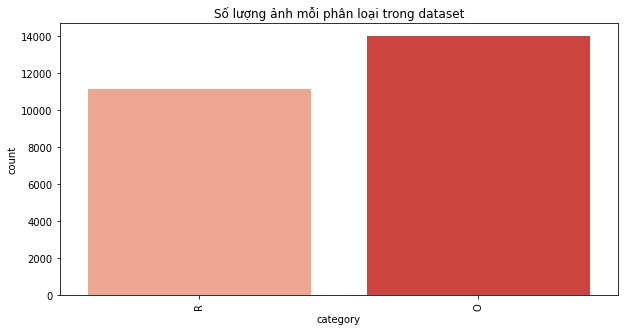

In [12]:
plt.figure(figsize=(10, 5))
sns.countplot(x="category", data=df, palette='Reds')
plt.xticks(rotation=90)
plt.title('Số lượng ảnh mỗi phân loại trong dataset')
plt.show()

## Chia dataset thành các tập Train, Test và Validation 

In [13]:
## Chia tập dataset ra các tập train, test, val với tỉ lệ  8:1:1
train, val = train_test_split(df, test_size=0.4, random_state=42)
val, test = train_test_split(val, test_size=0.5, random_state=42)

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)
len(train), len(val), len(test)

(15046, 5015, 5016)

# Build model CNN

In [14]:
im_shape = (256,256)
batch_size = 64
seed = 42

## Sử dụng ImageDataGenerator để làm dày dữ liệu

In [15]:
train_generator = ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         rescale=1./255,
                         validation_split=0.1,
                         rotation_range=40,
                         brightness_range= [1.1, 1.5],
                         zoom_range=0.2,
                         width_shift_range = 0.2,
                         height_shift_range = 0.2,
                         shear_range= 0.2,
                         fill_mode='nearest')
test_generator = ImageDataGenerator(rescale=1./255)
val_generator = ImageDataGenerator(rescale=1./255)


In [16]:
train_gen = train_generator.flow_from_dataframe(
    dataframe=train,
    directory=data_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

Found 15046 validated image filenames belonging to 2 classes.


In [17]:
val_gen = val_generator.flow_from_dataframe(
    dataframe=val,
    directory=data_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    class_mode='categorical', ## 2D
    batch_size=batch_size,
    seed=seed)

Found 5015 validated image filenames belonging to 2 classes.


In [18]:
test_gen = test_generator.flow_from_dataframe(
    dataframe=test,
    directory=data_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=seed)

Found 5016 validated image filenames belonging to 2 classes.


In [19]:
nb_train_samples = train_gen.samples ## là số lượng sample trong tập train 
nb_validation_samples = val_gen.samples ## là số lượng sample trong tập val
nb_test_samples = test_gen.samples ## là số lượng sample trong tập train test
classes = list(train_gen.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Classes: ['O', 'R']


## Xây dựng model gồm 5 lớp

In [20]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=(im_shape[0], im_shape[1], 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(im_shape[0], im_shape[1], 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid')) ## sigmoid

model.summary()
# compile model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

In [21]:
## Đặt giá trị epoch để train
epochs = 50
# Hàm callback để lưu lại model nào tốt nhất sử dụng EarlyStopping để dừng train nếu sau 10 epoch mà val_loss ko giảm
callbacks_list = [ModelCheckpoint(filepath='model_OnR_1.h5',monitor='val_loss', save_best_only=True, verbose=1),EarlyStopping(monitor='val_loss', patience=10,verbose=1)]
#Train model
history = model.fit(
        train_gen,
        steps_per_epoch=nb_train_samples // batch_size, 
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=val_gen,
        verbose = 1,
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
235/235 [==============================] - ETA: 0s - loss: 0.5216 - accuracy: 0.7601
Epoch 1: val_loss improved from inf to 0.41305, saving model to model_OnR_1.h5
235/235 [==============================] - 282s 1s/step - loss: 0.5216 - accuracy: 0.7601 - val_loss: 0.4131 - val_accuracy: 0.8311
Epoch 2/50
235/235 [==============================] - ETA: 0s - loss: 0.4522 - accuracy: 0.8058
Epoch 2: val_loss improved from 0.41305 to 0.37977, saving model to model_OnR_1.h5
235/235 [==============================] - 269s 1s/step - loss: 0.4522 - accuracy: 0.8058 - val_loss: 0.3798 - val_accuracy: 0.8440
Epoch 3/50
235/235 [==============================] - ETA: 0s - loss: 0.4352 - accuracy: 0.8179
Epoch 3: val_loss did not improve from 0.37977
235/235 [==============================] - 266s 1s/step - loss: 0.4352 - accuracy: 0.8179 - val_loss: 0.4135 - val_accuracy: 0.8399
Epoch 4/50
235/235 [==============================] - ETA: 0s - loss: 0.4090 - accuracy: 0.8234
Epoch 4: va

In [22]:
np.save('my_history.npy',history.history)

In [23]:
# history=np.load('my_history.npy',allow_pickle='TRUE').item()

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
model.save("/content/drive/MyDrive/lenguyentrung/model_OnR_1.h5")

In [26]:
model=load_model('/content/model_OnR_1.h5')

## Đánh giá mô hình

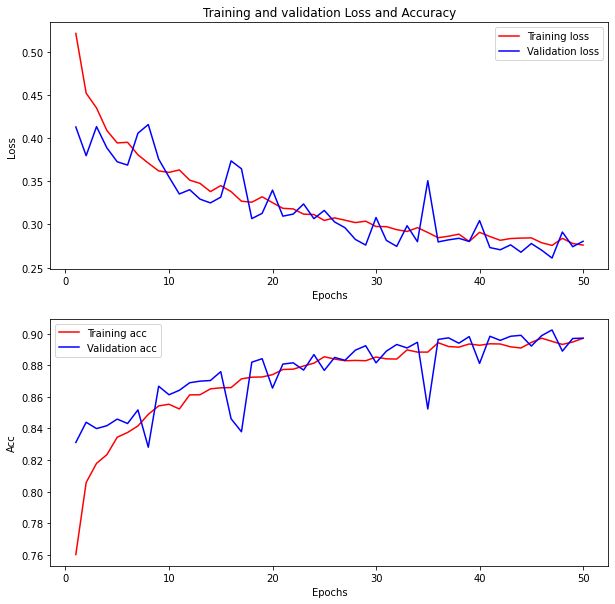

In [33]:
# Vẽ đường Training curves
his_dict = history.history
loss_values = his_dict['loss']
val_loss_values = his_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'r', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = his_dict['accuracy']
val_acc_values = his_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'r', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [28]:
# Using the validation dataset
score = model.evaluate(val_gen)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

79/79 [==============================] - 10s 118ms/step - loss: 0.2606 - accuracy: 0.9027
Val loss: 0.2606145441532135
Val accuracy: 0.9026919007301331


In [29]:
score = model.evaluate(test_gen)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

5016/5016 [==============================] - 24s 5ms/step - loss: 0.2538 - accuracy: 0.9031
Test loss: 0.25382983684539795
Test accuracy: 0.9031100273132324


In [30]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Classification Report


AttributeError: ignored

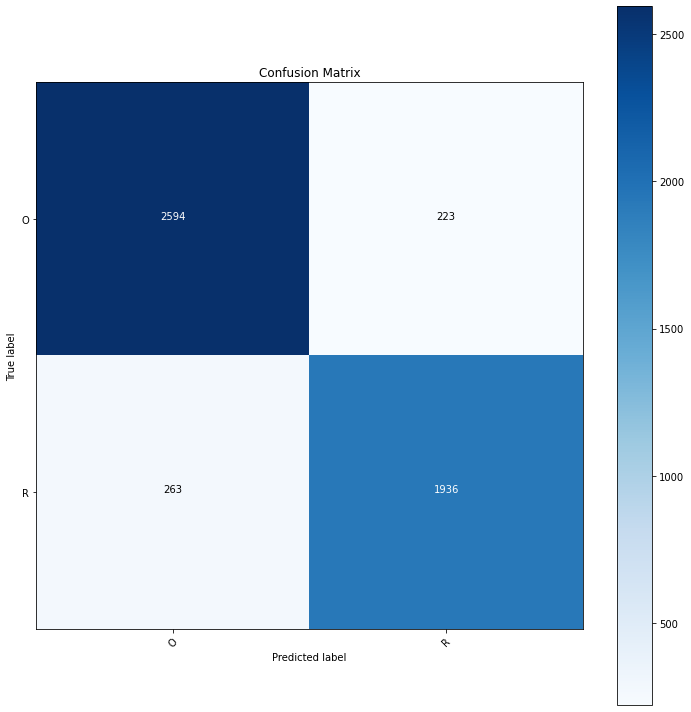

In [32]:
Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

# Confusion Matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

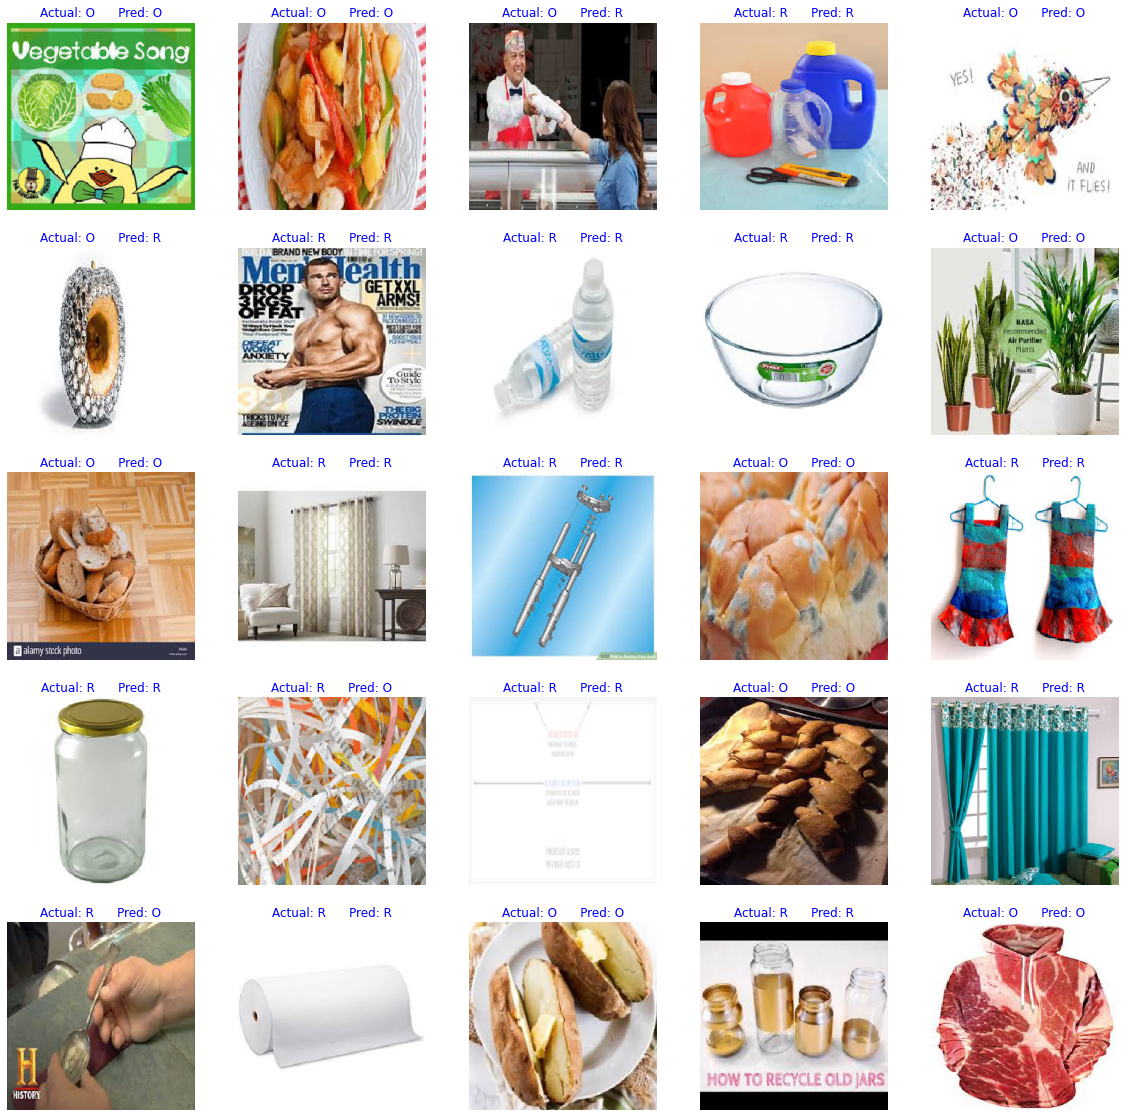

In [34]:
def test_image_samples(gen ):
    
        t_dict=gen.class_indices
        classes=list(t_dict.keys())    
        images,labels=next(gen) # get a sample batch from the generator 
        preds = model.predict(images)
        preds = preds.argmax(1)
        plt.figure(figsize=(20, 20))
        length=len(labels)
        if length<25:   #show maximum of 25 images
            r=length
        else:
            r=25
        for i in range(r):
            plt.subplot(5, 5, i + 1)
            image=images[i]
            plt.imshow(image)
            index=np.argmax(labels[i])
            class_name=classes[index]
            class_name_pred=classes[preds[i]]
            plt.title('Actual: {}      Pred: {}'.format(class_name,class_name_pred),  color='blue', fontsize=12)
            plt.axis('off')
        plt.show()

test_image_samples(val_gen)